In [2]:
import numpy as np
import pandas as pd
import time
import wrds
from matplotlib import pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
from math import *
np.random.seed(6078)
import warnings
from scipy.optimize import minimize
warnings.filterwarnings('ignore')
# from dask.multiprocessing import get
# import dask.dataframe as dd

In [3]:
idfile = pd.read_csv('secid_to_crsp.csv')

In [4]:
idfile.head()

,secid,sdate,edate,PERMNO,score
0,7621,19960101,20211231,78091,1
1,8170,19960101,20211231,80341,1
2,100861,19960102,20211231,76868,1
3,100862,19960102,20211231,54594,1
4,100863,19960102,20211231,80498,1


In [5]:
idfile['sdate'].min()

19960101

In [6]:
idfile['sdate'].max()

20211117

In [7]:
ids = idfile['secid'].unique()

In [8]:
pd.DataFrame(ids, columns=['secid']).to_csv("secids.csv")

In [9]:
opm = pd.read_csv('arkO.csv', nrows=20000)
opm.date = pd.to_datetime(opm.date, format='%Y-%m-%d')
opm.exdate = pd.to_datetime(opm.exdate, format='%Y-%m-%d')
opm = opm[(opm['exdate'] - opm['date'] == np.timedelta64(7, 'D'))]
opm.rename(columns={'ticker': 'TICKER'}, inplace=True)

In [10]:
opm.head()

,secid,date,symbol,exdate,cp_flag,strike_price,best_bid,best_offer,open_interest,optionid,...,vwretd,STRIKE,Year,LRVOL,SRVOL,tauDays,tau,RF,moneyness,spread
0,106367,2021-01-08,INTU 210115C100000,2021-01-15,C,100000,272.4,277.0,0,126855158,...,0.004688,100.0,2021,0.473418,1.076664,5,0.019841,0.0,-0.732949,4.6
1,106367,2021-01-08,INTU 210115C105000,2021-01-15,C,105000,267.4,272.0,0,126829040,...,0.004688,105.0,2021,0.473418,1.076664,5,0.019841,0.0,-0.719596,4.6
2,106367,2021-01-08,INTU 210115C110000,2021-01-15,C,110000,262.1,267.0,0,126829041,...,0.004688,110.0,2021,0.473418,1.076664,5,0.019841,0.0,-0.706244,4.9
3,106367,2021-01-08,INTU 210115C115000,2021-01-15,C,115000,257.1,262.0,0,124110559,...,0.004688,115.0,2021,0.473418,1.076664,5,0.019841,0.0,-0.692891,4.9
4,106367,2021-01-08,INTU 210115C120000,2021-01-15,C,120000,252.9,257.5,0,124110560,...,0.004688,120.0,2021,0.473418,1.076664,5,0.019841,0.0,-0.679539,4.6


In [11]:
opm.columns

Index(['secid', 'date', 'symbol', 'exdate', 'cp_flag', 'strike_price',
       'best_bid', 'best_offer', 'open_interest', 'optionid', 'cusip',
       'TICKER', 'index_flag', 'PERMNO', 'SHRCD', 'COMNAM', 'CUSIP', 'PRC',
       'VOL', 'RET', 'vwretd', 'STRIKE', 'Year', 'LRVOL', 'SRVOL', 'tauDays',
       'tau', 'RF', 'moneyness', 'spread'],
      dtype='object')

In [12]:
chain = opm[opm["exdate"] == '2021-01-22']
phain = chain[chain["cp_flag"] == "P"]
chain = chain[chain["cp_flag"] == "C"]
for i in range(len(chain.index) - 1)[::-1]:
    if chain.iloc[i]["best_bid"] < chain.iloc[i+1]["best_bid"]:
        chain.best_bid.iloc[i+1] = chain.iloc[i]["best_bid"]
    if chain.iloc[i+1]["best_offer"] > chain.iloc[i]["best_offer"]:
        chain.best_offer.iloc[i] = chain.iloc[i+1]["best_offer"]

for i in range(len(phain.index) - 1):
    if phain.iloc[i]["best_bid"] > phain.iloc[i+1]["best_bid"]:
        phain.best_bid.iloc[i+1] = phain.iloc[i]["best_bid"]
    if phain.iloc[i+1]["best_offer"] < phain.iloc[i]["best_offer"]:
        phain.best_offer.iloc[i] = phain.iloc[i+1]["best_offer"]

In [13]:
m = 1
deg = 100
min_K = chain.STRIKE.min()
max_K = chain.STRIKE.max()

def log_norm(x, mu, sig):
    return 1/(x * sig * np.sqrt(2 * np.pi)) * np.exp(-(np.log(x) - mu)**2 / (2 * sig ** 2))

vec = np.ones(3 * m)
for i in range(m):
    vec[3 * i] = np.log(np.random.rand() *(max_K - min_K) + min_K)
    
def func(vec):
    def f(x):
        tot = 0.0
        for i in range(m):
            tot += vec[3* i + 2] * log_norm(x, vec[3 * i], vec[3 * i + 1])
        return tot
    return f

def objective(vec):
    f = func(vec)
    vec[3 * m - 4:] = vec[3 * m - 4:] / np.sum(vec[3 * m - 4:])
    x_arr = np.linspace(min_K * 0.5, max_K * 1.5, 2 * deg)
    p_arr = [f(x_r) for x_r in x_arr]
    tot = 0.0
    for i in chain.index:
        Ki = chain.loc[i, "STRIKE"]
        po = np.maximum(x_arr - Ki, 0)
        tot += ((p_arr @ po) - chain.loc[i, "best_bid"] * 0.5 - chain.loc[i, "best_offer"] * 0.5) ** 2
    for i in phain.index:
        Ki = phain.loc[i, "STRIKE"]
        po = np.maximum(Ki - x_arr, 0)
        tot += ((p_arr @ po) - phain.loc[i, "best_bid"] * 0.5 - phain.loc[i, "best_offer"] * 0.5) ** 2
    return tot

# optimize
b1 = (0.0, np.log(max_K))
b2 = (0.0, 5.0)
b3 = (0.0, 1.0)

bnds = []
for i in range(m):
    bnds.append(b1)
    bnds.append(b2)
    bnds.append(b3)
bnds = np.array(bnds)
cons = ([])
solution = minimize(objective,vec,method='SLSQP',\
                    bounds=bnds,constraints=cons, jac="2-point")
solution

     fun: 146531.61689026913
     jac: array([-212393.94186237,  -48056.8125    ,      -0.        ])
 message: 'Optimization terminated successfully'
    nfev: 41
     nit: 12
    njev: 8
  status: 0
 success: True
       x: array([6.08083418, 0.15681348, 1.        ])

In [14]:
for i in range(m):
    print(f"theta_{i}={solution.x[3 * i + 2]}, a{i}={solution.x[3 * i]},  b{i}={solution.x[3 * i + 1]}")
solution.x

theta_0=1.0, a0=6.080834184419927,  b0=0.1568134786065204


array([6.08083418, 0.15681348, 1.        ])

<AxesSubplot:xlabel='K'>

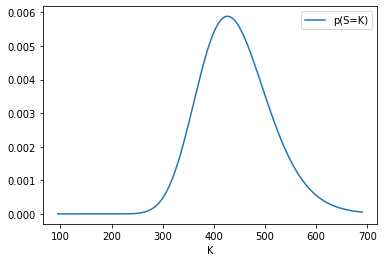

In [15]:
p = func(solution.x)
x_arr = np.linspace(min_K * 0.5, max_K * 1.5, 2 * deg)
p_arr = [p(x_r) for x_r in x_arr]
pd.DataFrame(np.c_[x_arr, p_arr], columns=["K", "p(S=K)"]).plot(x = "K", y="p(S=K)")

In [16]:
init = pd.read_csv('InitialOptionsData.csv')

In [17]:
init.head()

,secid,date,exdate,cp_flag,strike_price,volume,open_interest,impl_volatility,opprc,moneyness,tte,close,spread,noi
0,7621,20180102,20180420,P,2500,0,44,0.800399,1.075,1.712329,108,1.4600,0.15,44
1,7621,20180103,20180420,P,2500,0,44,1.180078,1.150,1.689303,107,1.4799,0.30,0
2,7621,20180104,20180119,P,2500,0,101,1.545111,0.975,1.623377,15,1.5400,0.35,101
3,7621,20180104,20180420,P,2500,0,44,0.768326,1.000,1.623377,106,1.5400,0.60,0
4,7621,20180105,20180420,P,2500,0,44,0.771142,0.975,1.592357,105,1.5700,0.15,0


In [18]:
earningsdates = pd.read_csv("earnings_dates_final.csv")

In [19]:
earningsdates.head()

,secid,edate_y
0,210354,20190417
1,210354,20220420
2,210354,20190717
3,210354,20180117
4,210354,20181017


In [20]:
earningsdates["exdate"] = pd.to_datetime(earningsdates["edate_y"].astype(str))
earningsdates.head()

,secid,edate_y,exdate
0,210354,20190417,2019-04-17
1,210354,20220420,2022-04-20
2,210354,20190717,2019-07-17
3,210354,20180117,2018-01-17
4,210354,20181017,2018-10-17


In [21]:
(init.exdate - init.date).min()

8

In [22]:
earningsdates['date'] = earningsdates['exdate'] - pd.to_timedelta(earningsdates['exdate'].dt.dayofweek + 4, unit='d')

In [23]:
earningsdates

,secid,edate_y,exdate,date
0,210354,20190417,2019-04-17,2019-04-11
1,210354,20220420,2022-04-20,2022-04-14
2,210354,20190717,2019-07-17,2019-07-11
3,210354,20180117,2018-01-17,2018-01-11
4,210354,20181017,2018-10-17,2018-10-11
...,...,...,...,...
25032,207854,20190311,2019-03-11,2019-03-07
25033,207854,20181108,2018-11-08,2018-11-01
25034,207854,20180802,2018-08-02,2018-07-26
25035,207854,20180508,2018-05-08,2018-05-03


In [24]:
earningsdates = earningsdates.drop(columns = ["edate_y"])

earningsdates

,secid,exdate,date
0,210354,2019-04-17,2019-04-11
1,210354,2022-04-20,2022-04-14
2,210354,2019-07-17,2019-07-11
3,210354,2018-01-17,2018-01-11
4,210354,2018-10-17,2018-10-11
...,...,...,...
25032,207854,2019-03-11,2019-03-07
25033,207854,2018-11-08,2018-11-01
25034,207854,2018-08-02,2018-07-26
25035,207854,2018-05-08,2018-05-03


In [25]:
earningsdates['exdate'] = earningsdates['date'] + pd.to_timedelta(8, unit='d')
#earningsdates = earningsdates.drop(columns = ["xdate"])
earningsdates

,secid,exdate,date
0,210354,2019-04-19,2019-04-11
1,210354,2022-04-22,2022-04-14
2,210354,2019-07-19,2019-07-11
3,210354,2018-01-19,2018-01-11
4,210354,2018-10-19,2018-10-11
...,...,...,...
25032,207854,2019-03-15,2019-03-07
25033,207854,2018-11-09,2018-11-01
25034,207854,2018-08-03,2018-07-26
25035,207854,2018-05-11,2018-05-03


In [26]:
earningsdates['exdate'] = earningsdates['exdate'].dt.strftime("%Y%m%d").astype(int)
earningsdates['date'] = earningsdates['date'].dt.strftime("%Y%m%d").astype(int)
earningsdates

,secid,exdate,date
0,210354,20190419,20190411
1,210354,20220422,20220414
2,210354,20190719,20190711
3,210354,20180119,20180111
4,210354,20181019,20181011
...,...,...,...
25032,207854,20190315,20190307
25033,207854,20181109,20181101
25034,207854,20180803,20180726
25035,207854,20180511,20180503


In [27]:
op_ids = init["secid"].unique()

In [28]:
earningsdates.head()["date"]

0    20190411
1    20220414
2    20190711
3    20180111
4    20181011
Name: date, dtype: int64

In [29]:
init.head()["date"]

0    20180102
1    20180103
2    20180104
3    20180104
4    20180105
Name: date, dtype: int64

In [30]:
merged_data = earningsdates.merge(init, on=['secid', 'date', 'exdate'])
merged_data

,secid,exdate,date,cp_flag,strike_price,volume,open_interest,impl_volatility,opprc,moneyness,tte,close,spread,noi
0,210354,20190719,20190711,C,14000,0,44,1.651489,8.550,0.622222,8,22.50,0.50,0
1,210354,20190719,20190711,C,18000,1,10,0.859370,4.550,0.800000,8,22.50,0.10,0
2,210354,20190719,20190711,C,19000,0,3,0.814534,3.600,0.844444,8,22.50,0.20,0
3,210354,20190719,20190711,C,20000,0,39,0.419988,2.525,0.888889,8,22.50,0.35,0
4,210354,20190719,20190711,C,21000,14,396,0.651550,1.800,0.933333,8,22.50,0.10,-40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80440,207854,20180316,20180308,C,7500,0,33,0.910852,1.575,0.830565,8,9.03,0.55,0
80441,207854,20180316,20180308,C,10000,0,35,0.808462,0.125,1.107420,8,9.03,0.15,0
80442,207854,20180316,20180308,P,10000,0,403,0.763558,1.075,1.107420,8,9.03,0.15,0
80443,207854,20180316,20180308,P,12500,0,286,1.261098,3.500,1.384275,8,9.03,0.60,1


In [31]:
merged_data.to_csv("merged_data.csv", index = False)

In [32]:
merged_data["STRIKE"] = merged_data["strike_price"] / 1000.0


In [33]:
def implied_median(chain):
    global df2
    global df3
    df3 = chain
    chain = chain.sort_values(["cp_flag", "STRIKE"]).reset_index()
    phain = chain[chain['cp_flag'] == 'P']
    chain = chain[chain['cp_flag'] == 'C']
    #prc = chain.PRC.max()
    #chain["CV"] = (chain["best_bid"] + chain["best_offer"]) / 2
    chain["CV"] = chain['opprc']
    #phain["PV"] = (phain["best_bid"] + phain["best_offer"]) / 2
    phain["PV"] = phain['opprc']
    chain = chain[["STRIKE", "CV"]]
    phain = phain[["STRIKE", "PV"]]
    df = chain.merge(phain, on='STRIKE')
    if len(df) < 4:
        return None
    df["V"] = df["CV"] + df["PV"]
    df = df.drop_duplicates(subset='STRIKE', keep="first").reset_index()
    df_d = df.shift(1)
    df_u = df.shift(-1)
    df["L0"] = df_d["V"] / ((df_d["STRIKE"] - df["STRIKE"]) * (df_d["STRIKE"] - df_u["STRIKE"]))
    df["L1"] = df["V"] / ((df["STRIKE"] - df_d["STRIKE"]) * (df["STRIKE"] - df_u["STRIKE"]))
    df["L2"] = df_u["V"] / ((df_u["STRIKE"] - df_d["STRIKE"]) * (df_u["STRIKE"] - df["STRIKE"]))
    df["IP"] = (df["L0"] + df["L1"] + df["L2"])
    df["PCDF"] = df["IP"].cumsum()
    df['PCDF'] = df['PCDF'] / df['PCDF'].max()
    df['IP'] = df['IP'] / df['PCDF'].max()
    df2 = df
    mid_idx = df[(df['PCDF'] > 0.5)].index[0]
    lb = df.loc[mid_idx-1, 'STRIKE']
    lbp = df.loc[mid_idx-1, 'PCDF']
    ub = df.loc[mid_idx, 'STRIKE']
    ubp = df.loc[mid_idx, 'PCDF']
    slope = (ubp - lbp) / (ub - lb)
    res = (0.5 - lbp) / slope + lb
    return res

#def implied_move(chain):
#    return implied_median(chain) / chain.PRC.max() - 1

In [34]:
df2 = None
df3 = None
meds = merged_data.groupby(["secid", "exdate"]).apply(implied_median)
meds

secid   exdate  
8170    20180615          NaN
        20190215          NaN
        20191115          NaN
100862  20181221          NaN
        20191220          NaN
                      ...    
213731  20190906    92.798688
213761  20191115          NaN
213776  20190920    29.750000
        20191213    24.308333
213814  20191115          NaN
Length: 2541, dtype: float64

In [35]:
meds = pd.DataFrame(meds)
meds

0
secid  exdate             
8170   20180615        NaN
       20190215        NaN
       20191115        NaN
100862 20181221        NaN
       20191220        NaN
...                    ...
213731 20190906  92.798688
213761 20191115        NaN
213776 20190920  29.750000
       20191213  24.308333
213814 20191115        NaN

[2541 rows x 1 columns]

In [36]:
meds = meds.dropna()

In [37]:
meds

0
secid  exdate             
100892 20180202  88.221154
       20180427  44.750000
       20180727  42.742188
       20181026  44.924242
       20190201  46.588542
...                    ...
213638 20190809  41.500000
       20191108  31.575000
213731 20190906  92.798688
213776 20190920  29.750000
       20191213  24.308333

[1649 rows x 1 columns]